## 3 REGRESSION APPROACHES (LEAFToolbox-SL2P + ALR)

This notebook contains code blocks to generate predictions based on three different treatment methods, which are as follows:
1. SL2P10 – using only the output from SL2P10_10m
2. LARS + Regression Tree – using feature selection (LARS) and smileCART (GEE function)
3. LARS + Neural Network – as implemented by Hemit in ALR_client_side

In [1]:
import ee
import time
import math
import csv
import json
import os
import numpy as np
import pandas as pd
import folium ; from folium import plugins
import matplotlib.pyplot as plt
import scipy ; from scipy import stats
import scipy.io as sio
import sklearn as skl ; from sklearn import linear_model ; from sklearn import preprocessing
import tensorflow as tf
import pickle
from collections import OrderedDict

# import custom modules:
import feature_collections as fc
import image_bands as ib
import wrapper_nets as wn
import ee_functions as ee_func
import ALR_functions as alr

ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWhHvLBmLrM1GYUyjj2QiVtPVUS7fQ5Tp9kLgyJGyWKpISmRaVw-USE



Successfully saved authorization token.


In [6]:
# -----------------------------------
# INPUT PARAMETERS / SETUP: TO MODIFY
# -----------------------------------
outputName = 'LAI'
    # product name, one of: 'Surface_Reflectance','Albedo','fAPAR','fCOVER','LAI','CCC','CWC','DASF'

siteSelect = 'FoxCreek'
    # site selection, one of: 'Geraldton', 'FoxCreek', 'Kouchibouguac'

outputParams = {
    'fAPAR': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    },
    'fCOVER': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    },
    'LAI': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 8
    }
}

outputScale = outputParams[outputName]['outputScale']
outputOffset = outputParams[outputName]['outputOffset']
outputMax = outputParams[outputName]['outputMax']
responseBand = 'estimate'+outputName

siteParams = {
    # Geraldton, ON
    'Geraldton': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200811T164849_20200811T165525_T16UEA'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-86, 49.5], \
                          [-86, 50], \
                          [-85.5, 50], \
                          [-85.5, 49.5]]])
    },
    # Fox Creek, AB
    'FoxCreek': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20210825T185919_20210825T190431_T11UNA'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-117, 54], \
                          [-117, 55], \
                          [-115, 55], \
                          [-115, 54]]])
    },
    # Kouchibouguac, NB
    'Kouchibouguac': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200905T151701_20200905T151829_T20TLS'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-65, 46], \
                          [-65, 47], \
                          [-64, 47], \
                          [-64, 46]]])
    }
}

mapBounds = siteParams[siteSelect]['mapBounds']
testImage = siteParams[siteSelect]['testImage']

# other filters
maxCloudcover = 10

# export parameters
exportFolder = siteSelect+'_'+outputName
exportScale = 20
exportDatatype = "int"

In [7]:
COLLECTION_OPTIONS = {
    # Sentinel 2 using 20 m bands:
    'COPERNICUS/S2_SR': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    # Sentinel 2 using 10 m bands:
    'COPERNICUS/S2_SR_10m': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    }
}

VIS_OPTIONS = {
    'fAPAR': {
        "COPERNICUS/S2_SR": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fCOVER': {
        "COPERNICUS/S2_SR": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        }
    },
    'LAI': {
        "COPERNICUS/S2_SR": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    }
}

In [8]:
# parse the networks
colName = 'COPERNICUS/S2_SR'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

### Original SL2P:

In [9]:
input_collection = ee.ImageCollection(testImage) \
                     .map(lambda image: ib.addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: ib.s2MaskClear(image)) \
                     .map(lambda image: ib.s2MaskLand(image)) \
                     .map(lambda image: ib.addS2Geometry(colOptions, image))

# get partition used to select network
partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')

# pre process input imagery and flag invalid inputs
scaled_input_collection = input_collection.map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                   .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))

# apply networks to produce mapped parameters
estimateSL2P = scaled_input_collection.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
uncertaintySL2P = scaled_input_collection.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))

# scale and offset mapped parameter bands
estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)), overwrite=True))
uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)), overwrite=True))

# produce final export collection
export_collection = input_collection.combine(estimateSL2P).combine(uncertaintySL2P)

image_output_names = ([name+"_"+outputName for name in export_collection.toList(export_collection.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset, mapBounds)

### SL2P10_20m and SL2P10_10m:

In [10]:
# parse the networks
colName = 'COPERNICUS/S2_SR_10m'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [11]:
# performs same procedure as above block using SL2P10 network
# reduces image resolution before applying algorithm
    
# filter collection and add ancillary bands
input_collection_20m = ee.ImageCollection(testImage) \
                     .map(lambda image: ib.addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: ib.s2MaskClear(image)) \
                     .map(lambda image: ib.s2MaskLand(image)) \
                     .map(lambda image: ib.addS2Geometry(colOptions, image)) \
                     .map(lambda image: ib.reduceTo20m(image))

# get partition used to select network
partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')

# pre process input imagery and flag invalid inputs
input_collection_20m = input_collection_20m.map(lambda image: ib.s2MaskLand(image)) \
                                           .map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                           .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))

# apply networks to produce mapped parameters
estimateSL2P_20m = input_collection_20m.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
uncertaintySL2P_20m = input_collection_20m.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))

# scale and offset mapped parameter bands
estimateSL2P_20m = estimateSL2P_20m.map(lambda image: image.addBands(image.select("estimate"+outputName) \
                                                           .multiply(ee.Image.constant(outputScale)) \
                                                           .add(ee.Image.constant(outputOffset)), overwrite = True))
uncertaintySL2P_20m = uncertaintySL2P_20m.map(lambda image: image.addBands(image.select("error"+outputName) \
                                                                 .multiply(ee.Image.constant(outputScale)) \
                                                                 .add(ee.Image.constant(outputOffset)),overwrite = True))

# produce final export collection
export_collection_20m = input_collection_20m.combine(estimateSL2P_20m).combine(uncertaintySL2P_20m)

image_output_names_20m = ([name+"_"+outputName+"_20m" for name in export_collection_20m.toList(export_collection_20m.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection_20m.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset, mapBounds)

## 1 – SL2P10

In [12]:
# performs same procedure as above block using SL2P10 network
# applies algorithm to 10 m bands ; generates a 10 m map

# filter collection and add ancillary bands
input_collection_10m = ee.ImageCollection(testImage) \
                     .map(lambda image: ib.addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: ib.s2MaskClear(image)) \
                     .map(lambda image: ib.s2MaskLand(image)) \
                     .map(lambda image: ib.addS2Geometry(colOptions, image))

# get partition used to select network
partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')

# pre process input imagery and flag invalid inputs
input_collection_10m = input_collection_10m.map(lambda image: ib.s2MaskLand(image)) \
                                           .map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                           .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))

# apply networks to produce mapped parameters
estimateSL2P_10m = input_collection_10m.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
uncertaintySL2P_10m = input_collection_10m.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))

# scale and offset mapped parameter bands
estimateSL2P_10m = estimateSL2P_10m.map(lambda image: image.addBands(image.select("estimate"+outputName) \
                                                             .multiply(ee.Image.constant(outputScale)) \
                                                             .add(ee.Image.constant(outputOffset)), overwrite = True))
uncertaintySL2P_10m = uncertaintySL2P_10m.map(lambda image: image.addBands(image.select("error"+outputName) \
                                                                   .multiply(ee.Image.constant(outputScale)) \
                                                                   .add(ee.Image.constant(outputOffset)),overwrite = True))


# produce final export collection
export_collection_10m = input_collection_10m.combine(estimateSL2P_10m).combine(uncertaintySL2P_10m)

image_output_names_10m = ([name+"_"+outputName+"_10m" for name in export_collection_10m.toList(export_collection_10m.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection_10m.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset, mapBounds)

In [13]:
# combine all SL2P, SL2P10_10m, SL2P10_20m bands into a single image to sample corresponding pixel values

export_20m = export_collection_20m.first()
export_10m = export_collection_10m.first()

export_20m = export_20m.select('estimate'+outputName).rename('estimate'+outputName+'_20m')
export_10m = export_10m.select('estimate'+outputName).rename('estimate'+outputName+'_10m')

# get the first image in export_collection ; add all bands from corresponding image in export_collection_10m and export_collection_10m
full_image = export_collection.first().addBands(export_20m).addBands(export_10m)

# sample the composed image with SL2P10_10m and SL2P10_20m bands
samples = full_image.select('estimate'+outputName, 'estimate'+outputName+'_20m', 'estimate'+outputName+'_10m').sample(numPixels=5000, projection=export_collection.first().select('estimate'+outputName)\
                                                             .projection(), scale=10).getInfo()

list_length = len(samples['features'])
estimate_list = []

# populate an array with the estimate for SL2P, SL2P10_10m, SL2P10_20m
for i in range(list_length):
    temp_list = []
    temp_list.append(samples['features'][i]['properties']['estimate'+outputName])
    temp_list.append(samples['features'][i]['properties']['estimate'+outputName+'_20m'])
    temp_list.append(samples['features'][i]['properties']['estimate'+outputName+'_10m'])
    estimate_list.append(temp_list)

estimate_array = pd.DataFrame(estimate_list).rename(columns={0:'estimate'+outputName, 1:'estimate'+outputName+'_20m', 2:'estimate'+outputName+'_10m'})

## ALR

In [14]:
# order of bands from SL2P output:
# 00-11: 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 
# 12-19: 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 
# 20-26: 'QA10', 'QA20', 'QA60', 'date', 'cosVZA', 'cosSZA', 'cosRAA', 
# 27-32: 'estimateLAI', 'partition', 'networkID', 'errorLAI', 'partition_1', 'networkID_1'

# define 10m band input image
inputImage = ee.Image('users/kateharvey/'+siteSelect+'_'+outputName).select(1,2,3,7,22,23,27,28,29,30,31,32)
inputImage_bands = ee.List(['B2', 'B3', 'B4', 'B8', 'QA60', 'date', 'estimate'+outputName, 'partition', 'networkID', 'error'+outputName, 'partition_1', 'networkID_1'])

# name bands of inputImage and scale response band
inputImage = inputImage.rename(inputImage_bands)
inputImage = inputImage.addBands(inputImage.select(responseBand).divide(outputScale), overwrite=True)

In [15]:
# Only include VIs that use 10 m bands (B2, B3, B4, B8)
input_VI_definition = ee.List(["RAW_B2  = b('B2')",
                               "RAW_B3  = b('B3')",
                               "RAW_B4  = b('B4')",
                               "RAW_B8  = b('B8')",
                               "GI      = b('B3')/b('B4')",
                             # "RVI3    = b('B4')/b('B6')",
                             # "SR3     = b('B5')/b('B4')",
                             # "GM1     = b('B6')/b('B3')",
                             # "GM2     = b('B6')/b('B5')",
                             # "SR2     = b('B7')/b('B3')",
                             # "PSSR    = b('B7')/b('B4')",
                               "SGI     = b('B8')/b('B4')",
                             # "MSI     = b('B11')/b('B7')",
                             # "II      = b('B11')/b('B12')",
                               "GVI     = (b('B8')/b('B3'))-1",
                             # "PSRI    = (b('B4')-b('B3'))/b('B6')",
                               "NDVI3   = ((b('B8')-b('B4'))/(b('B8')))+b('B4')",
                             # "SR5     = 1/b('B5')",
                             # "SR6     = b('B4')/(b('B3')*b('B5'))",
                             # "SR7     = b('B8')/(b('B3')*b('B5'))",
                             # "IPVI    = b('B7')/(b('B7')+b('B4'))",
                             # "ARI     = (1/b('B3'))-(1/b('B5'))",
                             # "ARI2    = b('B7')*((1/b('B3'))-(1/b('B5')))",
                               "NDVI    = (b('B8')-b('B4'))/(b('B8')+b('B4'))",
                               "GNDVI   = (b('B8')-b('B3'))/(b('B8')+b('B3'))",
                             # "NDWI    = (b('B8')-b('B11'))/(b('B8')+b('B11'))",
                             # "NDREVI  = (b('B8')-b('B5'))/(b('B8')+b('B5'))",
                               "NDGI    = (b('B3')-b('B4'))/(b('B3')+b('B4'))",
                             # "NDI1    = (b('B7')-b('B5'))/(b('B7')-b('B4'))",
                             # "NDI2    = (b('B8')-b('B5'))/(b('B8')-b('B4'))",
                             # "RENDVI  = (b('B6')-b('B5'))/(b('B6')+b('B5'))",
                             # "OSAVI   = (1.16*(b('B7')-b('B4')))/(b('B7')+b('B4')+0.61)",
                             # "NMDI    = (b('B8')-(b('B11')-b('B12')))/(b('B8')+(b('B11')-b('B12')))",
                             # "HI      = ((b('B3')-b('B5'))/(b('B3')+b('B5')))-0.5*b('B5')",
                             # "GVSP    = (-0.283*b('B3') - 0.66*b('B4') + 0.577*b('B6') + 0.388*b('B8'))/(0.433*b('B3') - 0.632*b('B4') + 0.586*b('B6') + 0.264*b('B8A'))",
                             # "MCARI   = ((b('B5')-b('B4'))-0.2*(b('B5')-b('B3')))*(b('B5')/b('B4'))",
                             # "TCARI   = 3*((b('B5')-b('B4'))-0.2*(b('B5')-b('B3'))*(b('B5')/b('B4')))",
                               "EVI     = 2.5*((b('B8')-b('B4'))/(b('B8')+6*b('B4')-7.5*b('B3')+1))",
                               "EVI2    = 2.5*((b('B8')-b('B4'))/(b('B8')+2.4*b('B4')+1))",
                               "RDVI    = (b('B8')-b('B4'))/((b('B8')+b('B4'))**0.5)",
                               "MSR     = ((b('B8')/b('B4'))-1)/((b('B8')/b('B4'))**0.5+1)",
                             # "MSAVI   = 0.5*(2*b('B7')+1-((2*b('B7')+1)**2-8*(b('B7')-b('B4')))**0.5)",
                               "MSAVI2  = 0.5*(2*b('B8')+1-((2*b('B8')+1)**2-8*(b('B8')-b('B4')))**0.5)",
                             # "MCARI2  = (1.5*(2.5*(b('B7')-b('B4'))-1.3*(b('B7')-b('B3'))))/((((2*b('B7')+1)**2)-(6*b('B7')-5*(b('B4')**0.5))-0.5)**0.5)",
                             # "MTVI2   = (1.5*(1.2*(b('B7')-b('B3'))-2.5*(b('B4')-b('B3'))))/(((2*b('B7')+1)**2-(6*b('B7')-5*b('B4'))-0.5)**0.5)",
                             # "MSR2    = ((b('B7')/b('B4'))-1)/(((b('B7')/b('B4'))+1)**0.5)",
                               "NLI     = ((b('B8')**2)-b('B4'))/((b('B8')**2)+b('B4'))"])

In [16]:
# format image and generate list of selected features
inputImage = alr.format_image(inputImage, inputImage_bands, responseBand, input_VI_definition)

In [17]:
num_input_pixels = alr.get_num_pixels(inputImage)

In [18]:
scaledImage = alr.scale_image(inputImage, responseBand)

In [19]:
input_bandNames = ['B2', 'B3', 'B4', 'B8', 'GI', 'SGI', 'GVI', 'NDVI3', 'NDVI', 'GNDVI', 'NDGI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI2', 'NLI']

In [20]:
select_features = alr.ee_LARS(scaledImage, input_bandNames, responseBand, 5, 10000)

selected features:  ['MSR', 'GVI', 'RDVI', 'SGI', 'EVI2']


## 2 – LARS + Regression Tree

a few notes:
1. the responseBand from the above step doesn't have a geometry associated with it (only happens after being uploaded to GEE) so the image will have to be defined from existing GEE asset for the remaining steps even though the same image was created as inputImage (should be identical except for geometry)

In [42]:
regression_image = ee.Image('users/kateharvey/'+siteSelect+'_'+outputName).select(1,2,3,7,22,23,27,28,29,30,31,32)
regression_bands = ee.List(['B2', 'B3', 'B4', 'B8', 'QA60', 'date', 'estimate'+outputName, 'partition', 'networkID', 'error'+outputName, 'partition_1', 'networkID_1'])
regression_image = regression_image.rename(regression_bands)

sl2p_estimate = regression_image.select(responseBand).addBands(regression_image.select(responseBand).divide(outputScale), overwrite=True)
nnet_inputs = scaledImage.select(select_features)

In [43]:
# from Hemit's ALR_server_side example: can save FeatureCollection as EE asset to ensure consistent sampling

# sample input image into feature collection for training:
training_features = scaledImage.sample(numPixels=1000)

In [44]:
# implement regression tree with smileCART function
    # optional parameters for smileCart(): maxNodes, minLeafPopulation
cart_regression = ee.Classifier.smileCart().setOutputMode("REGRESSION").train(features=training_features,
                                                                              classProperty=responseBand,
                                                                              inputProperties=select_features)

In [45]:
# make predictions with smileCart regressor
cart_prediction = nnet_inputs.addBands(sl2p_estimate).classify(cart_regression, "CART_REGRESSION")

In [46]:
cart_prediction.getInfo()

{'type': 'Image',
 'bands': [{'id': 'CART_REGRESSION',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [5489, 5308],
   'origin': [25000, -304819],
   'crs': 'EPSG:32611',
   'crs_transform': [20, 0, 0, 0, -20, 0]}]}

## 3 – LARS + NNET
Same procedure as in ALR_client_side_10m.ipynb – export csv, generate model, train, and predict

In [47]:
# Create the export task on the server side from Earth Engine. Remember that the data will be exported to the google drive of the google
# account you used when you initiated the Earth Engine API authentication flow, so ensure that, that accounts drive is synced to the 
# gdrive folder in the same folder as this script
trimmedCollection = alr.trim_data(image=inputImage.updateMask(inputImage.select(responseBand).gt(0)),
                                  selected_features=select_features,
                                  response_band=responseBand,
                                  num_samples=10000,
                                  num_partitions=10)

exportData = ee.batch.Export.table.toDrive(collection=trimmedCollection,
                                           description=siteSelect+'_'+outputName+'_10m',
                                           fileFormat="CSV")

# Start the export data task
exportData.start()

# Wait loop to see if the data has finished exporting by checking with the server-side
prev_task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
print(prev_task_status)
while exportData.active():
    task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
    if(task_status != prev_task_status):
        print(task_status)
    prev_task_status = task_status
    time.sleep(5)
print(ee.data.getTaskStatus(exportData.id)[0]["state"])

READY
RUNNING
COMPLETED


In [48]:
# Read the CSV file into dataframes
trimmed_data = pd.read_csv('./gdrive/'+siteSelect+'_'+outputName+'_10m'+'.csv')
X = trimmed_data.drop(labels=[responseBand, 'system:index', '.geo'], axis=1)
y = trimmed_data[responseBand]

# Preprocess the input features by standardizing them to a mean of 0 and a standard deviation of 1 for the neural network
X = pd.DataFrame(skl.preprocessing.scale(X))

In [49]:
# Use Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
LAI_model = alr.make_nets(X, y)

2021-11-12 15:44:42.767192: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-12 15:44:43.120717: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
230/230 [==============================] - 4s 4ms/step - loss: 3.8100 - mse: 3.8100 - mae: 1.8896
Epoch 2/100
230/230 [==============================] - 1s 4ms/step - loss: 1.4686 - mse: 1.4686 - mae: 1.1326
Epoch 3/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4779 - mse: 0.4779 - mae: 0.5845
Epoch 4/100
230/230 [==============================] - 1s 3ms/step - loss: 0.1829 - mse: 0.1829 - mae: 0.3189
Epoch 5/100
230/230 [==============================] - 1s 4ms/step - loss: 0.1037 - mse: 0.1037 - mae: 0.2391
Epoch 6/100
230/230 [==============================] - 1s 2ms/step - loss: 0.0769 - mse: 0.0769 - mae: 0.2114
Epoch 7/100
230/230 [==============================] - 1s 3ms/step - loss: 0.0660 - mse: 0.0660 - mae: 0.2004
Epoch 8/100
230/230 [==============================] - 1s 2ms/step - loss: 0.0595 - mse: 0.0595 - mae: 0.1894
Epoch 9/100
230/230 [==============================] - 1s 3ms/step - loss: 0.0525 - mse: 0.0525 - mae: 0.1780
Epoch 10/1

In [50]:
# Predict our input data to evaluate the performance (for now)
LAI_predictions = pd.Series(LAI_model.predict(X.to_numpy()).flatten())

# Prepare data to display as a scatterplot
xy_tf_LAI = np.vstack([y, LAI_predictions])
z_tf_LAI = scipy.stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

idx_tf_LAI = z_tf_LAI.argsort()
x_tf_LAI = y[idx_tf_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

rmse_tf_LAI = skl.metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

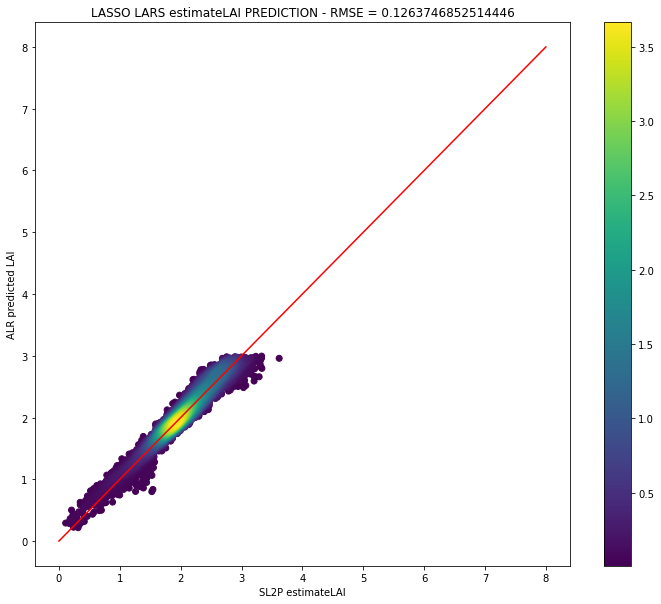

In [51]:
a_tf_LAI = np.linspace(0, outputMax, 1000)
fig, ax = plt.subplots(1, 1, figsize=(12,10))

fig1 = ax.scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
ax.plot(a_tf_LAI, a_tf_LAI, c='r')
ax.set_xlabel('SL2P {}'.format(responseBand))
ax.set_ylabel('ALR predicted {}'.format(outputName))
plt.colorbar(mappable=fig1, ax=ax)

ax.title.set_text('LASSO LARS {} PREDICTION - RMSE = {}'.format(responseBand, rmse_tf_LAI))

In [52]:
LAI_model.get_weights()

[array([[-0.35929236, -0.7686548 ,  0.24856244,  0.15120654,  0.71841127],
        [-0.4662813 ,  0.06420498,  0.5751292 ,  0.3701798 , -0.10019162],
        [-0.19088252,  0.01073985, -0.47818655,  0.22369958,  0.3756377 ],
        [-0.20718846, -0.6642304 , -0.00290102,  0.6743471 ,  0.24870507],
        [-0.47477716,  0.50568503,  0.2198214 , -0.5793812 ,  0.51065713]],
       dtype=float32),
 array([ 0.27132338,  0.814708  , -0.4327983 ,  0.4972251 ,  0.09490421],
       dtype=float32),
 array([[-0.05739254, -0.1821713 , -0.5048128 , -0.62697905],
        [-0.5252487 , -0.9762297 ,  0.36557984, -0.29146826],
        [ 0.8237568 ,  0.33804968, -0.89946944, -0.09760635],
        [-0.42545104, -0.5163717 ,  0.35329258, -0.5421472 ],
        [ 0.07783852, -0.5838992 , -0.5446625 , -0.5875595 ]],
       dtype=float32),
 array([-0.32021636, -0.200793  ,  0.10362165, -0.38773885], dtype=float32),
 array([[-1.0357032 , -0.40299645,  0.40212166],
        [-0.32560867,  1.2861769 , -0.900088

In [53]:
elu = np.vectorize(alr.elu)
softplus = np.vectorize(alr.softplus)
softsign = np.vectorize(alr.softsign)
relu = np.vectorize(alr.relu)
tanh = np.vectorize(alr.tanh)
sigmoid = np.vectorize(alr.sigmoid)

In [54]:
row = 4802
inputs = X.iloc[row, :].to_numpy()
print(LAI_model.predict(inputs.reshape((-1,5)))[0][0])
print(alr.apply_nnet(inputs, LAI_model)[0])

2.175882
2.1758821600692198


In [55]:
# Writing the neural network to a CSV file to be uploaded to the server side on Google Earth Engine
export_data = alr.export_nnet(LAI_model, X)
with open('nnet.csv', 'w', newline='') as csvfile:
    nnet_writer = csv.writer(csvfile)
    for layerdata in export_data:
        nnet_writer.writerow(layerdata)

## Consolidation
Compare results from all three methods